<a href="https://colab.research.google.com/github/prikmm/MLprojects/blob/main/notebooks/CV_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

In [2]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

(-0.5, 639.5, 426.5, -0.5)

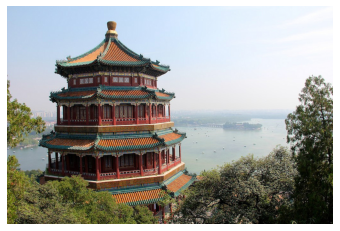

In [3]:
plt.imshow(china)
plt.axis("off")

(-0.5, 639.5, 426.5, -0.5)

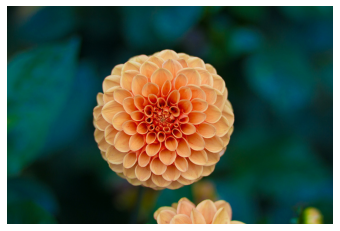

In [4]:
plt.imshow(flower)
plt.axis("off")

In [5]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [6]:
images.shape

(2, 427, 640, 3)

(2, 427, 640, 2)


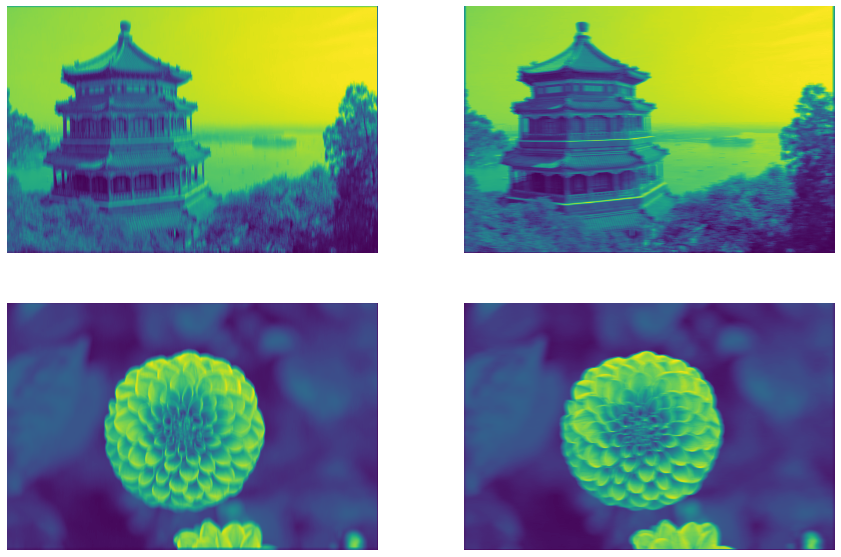

In [7]:
filters = np.zeros(shape=(10, 10, channels, 2), dtype=np.float32)
filters[:, 5, :, 0] = 1     # vertical line
filters[5, :, :, 1] = 1     # horizontal line
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
print(outputs.shape)
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
axs[0, 0].imshow(outputs[0, :, :, 0])
axs[0, 1].imshow(outputs[0, :, :, 1])
axs[1, 0].imshow(outputs[1, :, :, 0])
axs[1, 1].imshow(outputs[1, :, :, 1])
axs[0, 0].axis("off")
axs[0, 1].axis("off")
axs[1, 0].axis("off")
axs[1, 1].axis("off")
plt.show()

In [8]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="same", activation="relu")

## Pooling Layers:

In [9]:
import matplotlib as mpl

In [10]:
def crop(images):
    return images[150:220, 130:250]

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

### Max Pooling:

In [11]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [12]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

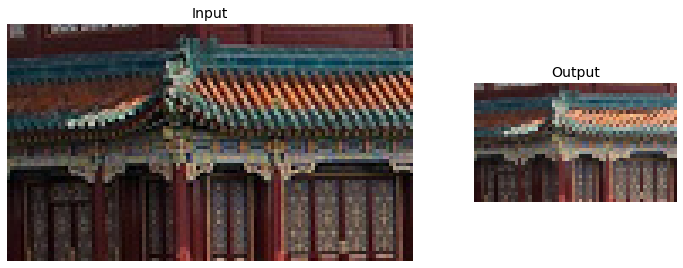

In [13]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")

plt.show()

### Depthwise Pooling:

In [14]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return tf.nn.max_pool(inputs, ksize=(1, 1, 1, self.pool_size),
                              strides = (1, 1, 1, self.pool_size),
                              padding = self.padding)

In [15]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

#### Or Using Lambda layer:

In [16]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
                        X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                        padding="VALID"
                    ))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

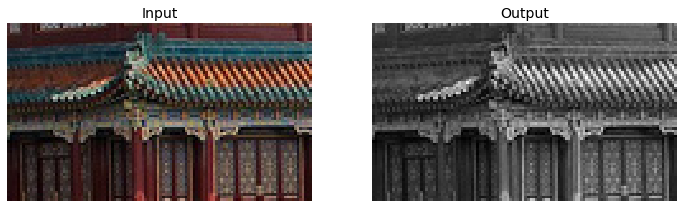

In [17]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

### Average Pooling:

In [18]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [19]:
output_avg = avg_pool(cropped_images)

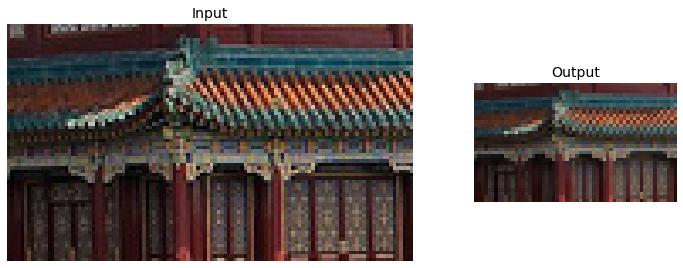

In [20]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

### Global Average Pooling:

In [21]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [22]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

### Complete CNN architecture:

In [23]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [24]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                        input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(lr=3e-4),
              metrics=["accuracy"])

In [25]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 37s 20ms/step - loss: 1.1170 - accuracy: 0.6102 - val_loss: 0.3876 - val_accuracy: 0.8542
Epoch 2/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.4773 - accuracy: 0.8422 - val_loss: 0.3027 - val_accuracy: 0.8864
Epoch 3/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3712 - accuracy: 0.8808 - val_loss: 0.2666 - val_accuracy: 0.9000
Epoch 4/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3176 - accuracy: 0.8954 - val_loss: 0.2599 - val_accuracy: 0.9038
Epoch 5/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2759 - accuracy: 0.9070 - val_loss: 0.2513 - val_accuracy: 0.9098
Epoch 6/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2371 - accuracy: 0.9213 - val_loss: 0.2466 - val_accuracy: 0.9068
Epoch 7/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2121 - accuracy: 0.9290 - val_loss: 0.2577 -

## Implementing ResNet-34:

In [26]:
class ResidualUnits(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnits(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_units (ResidualUnit (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_units_1 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_units_2 (ResidualUn (None, 56, 56, 64)       

#### Pre-trained Models:

In [29]:
import tensorflow_datasets as tfds

In [30]:
dataset, info = tfds.load("tf_flowers",
                          split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'],
                          as_supervised=True,
                          with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [31]:
train_set, valid_set, test_set = dataset

In [32]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [33]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [34]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [35]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
69/69 [==============================] - 37s 456ms/step - loss: 2.0599 - accuracy: 0.6668 - val_loss: 1.0169 - val_accuracy: 0.8501
Epoch 2/5
69/69 [==============================] - 28s 408ms/step - loss: 0.5435 - accuracy: 0.8985 - val_loss: 0.6737 - val_accuracy: 0.8747
Epoch 3/5
69/69 [==============================] - 29s 417ms/step - loss: 0.2791 - accuracy: 0.9282 - val_loss: 0.6725 - val_accuracy: 0.8842
Epoch 4/5
69/69 [==============================] - 28s 408ms/step - loss: 0.1161 - accuracy: 0.9671 - val_loss: 0.6791 - val_accuracy: 0.8678
Epoch 5/5
69/69 [==============================] - 28s 409ms/step - loss: 0.0935 - accuracy: 0.9690 - val_loss: 0.6117 - val_accuracy: 0.8828


In [37]:
for layers in base_model.layers:
    layer.trainable = True

In [38]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
69/69 [==============================] - 32s 422ms/step - loss: 0.0450 - accuracy: 0.9868 - val_loss: 0.6053 - val_accuracy: 0.8801
Epoch 2/5
69/69 [==============================] - 29s 419ms/step - loss: 0.0521 - accuracy: 0.9866 - val_loss: 0.6065 - val_accuracy: 0.8774
Epoch 3/5
69/69 [==============================] - 29s 416ms/step - loss: 0.0388 - accuracy: 0.9927 - val_loss: 0.6067 - val_accuracy: 0.8774
Epoch 4/5
69/69 [==============================] - 29s 415ms/step - loss: 0.0318 - accuracy: 0.9932 - val_loss: 0.6048 - val_accuracy: 0.8801
Epoch 5/5
69/69 [==============================] - 28s 409ms/step - loss: 0.0283 - accuracy: 0.9944 - val_loss: 0.6098 - val_accuracy: 0.8787


## Classification and Localization:

In [39]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input,
                         outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, 
              metrics=["accuracy"]) 

In [40]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [41]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2


5/5 [==============================] - 13s 1s/step - loss: 1.2979 - dense_5_loss: 1.6223 - dense_5_accuracy: 0.2297 - dense_6_accuracy: 0.2671
Epoch 2/2
5/5 [==============================] - 6s 1s/step - loss: 1.1967 - dense_5_loss: 1.4959 - dense_5_accuracy: 0.3489 - dense_6_accuracy: 0.2551


### Mean Average Precision:

In [42]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))


In [43]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
print(max_precisions)

[0.96 0.96 0.96 0.95 0.95 0.92 0.8  0.6  0.45 0.2  0.1 ]


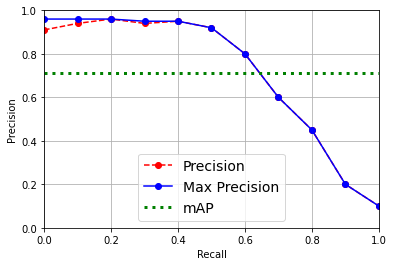

In [44]:
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [48]:
tf.random.set_seed(42)
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3,
                                              strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

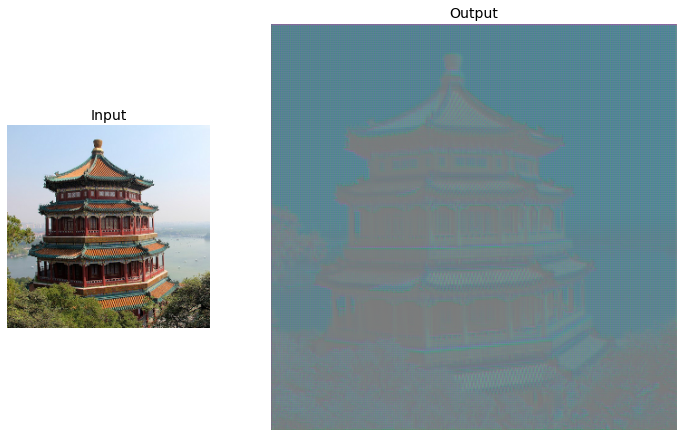

In [53]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")
ax2.axis(False)
plt.show()

In [54]:
def upscaled_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size -1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [55]:
upscaled = upscaled_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

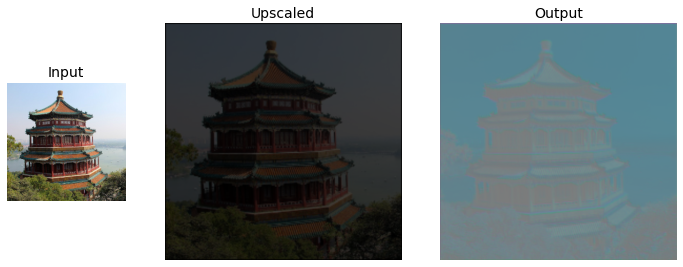

In [58]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()